# Digit Recognition using Extracted MFCC features

### Loading Pretrained Models from files

In [53]:
#Loading
models = []
for i,word in enumerate(word_dict.values()):
    with open(f"{word}_model.pkl", "rb") as file: models.append(pickle.load(file))

### If pretrained models are not there, start running cells from here for training and prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import soundfile as sf
import librosa


import warnings
warnings.filterwarnings("ignore")

In [4]:
from hmmlearn.hmm import GaussianHMM, GMMHMM

# Training Data

### Loading the data from saved csv files

In [5]:
df = pd.read_csv('mfcc_librosa_NEW.csv')
metadata = pd.read_csv('metadata.csv')

In [35]:
word_df = df.loc[df['Word'] == 'yes'].iloc[:] #just to see files corresponding to word "yes"
X = word_df.iloc[:,4:]

In [36]:
word_df

,Unnamed: 0,Filepath,Word,FrameIndex,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,ddel3,ddel4,ddel5,ddel6,ddel7,ddel8,ddel9,ddel10,ddel11,ddel12
0,0,Commands Dataset/train/yes/2a89ad5c_nohash_1.wav,yes,0,-556.390043,27.343620,-5.926212,20.465272,2.157070,12.225427,...,-0.290353,-0.077619,-0.276061,0.722445,-0.195298,-0.301675,-0.046899,0.386382,0.197786,0.164858
1,1,Commands Dataset/train/yes/2a89ad5c_nohash_1.wav,yes,1,-682.180862,11.767795,-1.331201,18.119935,13.049583,31.033364,...,-0.745812,-1.045512,-0.969724,0.574377,-1.647343,0.052351,-0.790390,0.064325,0.096302,0.667181
2,2,Commands Dataset/train/yes/2a89ad5c_nohash_1.wav,yes,2,-678.435525,15.322147,4.310124,19.801094,-2.513502,22.049934,...,-1.874895,-0.273846,-1.286198,-0.430326,-1.079999,0.622694,-0.848668,0.166498,-0.945078,0.236001
3,3,Commands Dataset/train/yes/2a89ad5c_nohash_1.wav,yes,3,-683.519680,21.696026,2.631784,13.992663,-7.031582,15.784825,...,-1.377318,0.322976,-1.395745,-1.218197,-1.084029,0.686035,-1.112743,-0.610438,-1.409471,0.276336
4,4,Commands Dataset/train/yes/2a89ad5c_nohash_1.wav,yes,4,-688.997273,5.807549,7.837404,22.987902,9.222761,25.372898,...,-0.159356,0.626948,-0.730188,-1.151507,0.153668,0.102861,0.063793,-0.219122,-1.252462,-0.398920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81126,81126,Commands Dataset/train/yes/f17be97f_nohash_4.wav,yes,14,-360.269038,28.823941,-70.274640,54.581071,-40.919127,-3.086882,...,-1.352330,1.201535,-1.302386,-0.748924,-0.036124,-2.637077,-1.039365,-0.720427,1.269370,-3.038424
81127,81127,Commands Dataset/train/yes/f17be97f_nohash_4.wav,yes,15,-342.134606,30.696869,-49.019340,50.363136,-36.466465,2.892531,...,-2.327912,2.675832,-0.729212,2.114944,-0.290756,-0.112265,-1.232672,0.235367,0.133221,-1.594221
81128,81128,Commands Dataset/train/yes/f17be97f_nohash_4.wav,yes,16,-368.842702,3.397642,-46.344596,44.155096,-52.875322,-2.712790,...,-1.498102,2.818709,-0.988037,3.002854,-0.702026,1.396800,-1.941030,-0.232133,-0.761172,0.153721
81129,81129,Commands Dataset/train/yes/f17be97f_nohash_4.wav,yes,17,-400.637593,-28.473486,-63.040842,33.013728,-39.621527,6.921384,...,0.371980,2.481579,-0.687356,2.961369,-0.848311,2.708376,-1.986614,0.089083,-1.204288,2.047903


In [37]:
X.shape

(81131, 39)

### Training the HMM models

We use the GaussianHMM function from hmmlearn to train an HMM model for each word

- n_components denotes the number of states in the HMM
- n_itee denotes the maximum number of iterations while training (if tolerance is not reached by convergence)
- tol denotes the convergence threshold. The algorithm will stop if the gain in log-likelihood is below this value.


The .fit method accepts two arguments:

- X: the feature matrix corresponding to our files (shape: (total #frames for that word, 39))
- lengths: a list containing number of frames in each utterance. The sum of its entries should be equal to the total number of frames in the feature matrix X

In [8]:
# Training Code

models = [] #list which will ultimately contain 10 models, 1 for each word

for word in df['Word'].unique():
    
    word_df = df.loc[df['Word'] == word] #take entries corresponding to that word
    X = word_df.iloc[:,4:] #39 dimensional feature matrix
    lengths = []
    for i in range(len(word_df['Filepath'].unique())):
        lengths.append(len(word_df.loc[word_df['Filepath'] == word_df['Filepath'].unique()[i]]))
    
    word_gmm = GaussianHMM(n_components = 15, n_iter =500, tol = 0.001,
                           verbose = True, random_state=100).fit(X, lengths) #the model
    models.append(word_gmm)
    print('Word', word, 'completed')

         1   -10211888.2215             +nan
         2    -9783557.2064     +428331.0152
         3    -9652170.6067     +131386.5997
         4    -9569413.1656      +82757.4411
         5    -9506730.9638      +62682.2019
         6    -9468367.3702      +38363.5935
         7    -9455790.2028      +12577.1674
         8    -9448482.5940       +7307.6088
         9    -9443116.1881       +5366.4059
        10    -9439215.0685       +3901.1196
        11    -9436595.1707       +2619.8978
        12    -9434520.5740       +2074.5967
        13    -9432603.7731       +1916.8009
        14    -9430721.2180       +1882.5551
        15    -9428762.7826       +1958.4354
        16    -9426208.4153       +2554.3673
        17    -9421524.5366       +4683.8787
        18    -9413918.6635       +7605.8732
        19    -9408816.5188       +5102.1446
        20    -9405635.7862       +3180.7326
        21    -9403062.3571       +2573.4291
        22    -9400957.7573       +2104.5999
        23

       184    -9382546.1082         +74.8849
       185    -9382215.9956        +330.1126
       186    -9382046.6882        +169.3074
       187    -9381990.6356         +56.0526
       188    -9381971.3618         +19.2737
       189    -9381963.2662          +8.0956
       190    -9381959.1882          +4.0781
       191    -9381956.8932          +2.2949
       192    -9381955.4839          +1.4093
       193    -9381954.5629          +0.9210
       194    -9381953.9276          +0.6353
       195    -9381953.4687          +0.4589
       196    -9381953.1242          +0.3445
       197    -9381952.8569          +0.2673
       198    -9381952.6436          +0.2133
       199    -9381952.4692          +0.1744
       200    -9381952.3236          +0.1455
       201    -9381952.2000          +0.1236
       202    -9381952.0935          +0.1065
       203    -9381952.0006          +0.0929
       204    -9381951.9188          +0.0818
       205    -9381951.8461          +0.0727
       206

Word yes completed


         1    -8735892.2602             +nan
         2    -8391290.5807     +344601.6795
         3    -8279735.0027     +111555.5780
         4    -8218774.8251      +60960.1775
         5    -8190788.0738      +27986.7514
         6    -8172156.3480      +18631.7258
         7    -8154301.7479      +17854.6000
         8    -8141316.3391      +12985.4088
         9    -8125663.7512      +15652.5878
        10    -8109208.6466      +16455.1046
        11    -8103346.4052       +5862.2415
        12    -8100394.5429       +2951.8622
        13    -8097202.7244       +3191.8186
        14    -8094235.5420       +2967.1824
        15    -8091335.8958       +2899.6462
        16    -8088768.5291       +2567.3666
        17    -8087122.4934       +1646.0358
        18    -8085899.5645       +1222.9289
        19    -8084896.3691       +1003.1954
        20    -8084224.9564        +671.4127
        21    -8083816.9636        +407.9928
        22    -8083557.8631        +259.1006
        23

       184    -8077719.0455         +18.6565
       185    -8077703.6184         +15.4272
       186    -8077690.7835         +12.8348
       187    -8077680.0198         +10.7637
       188    -8077670.8646          +9.1552
       189    -8077662.8190          +8.0456
       190    -8077655.3322          +7.4868
       191    -8077647.5064          +7.8258
       192    -8077638.7209          +8.7855
       193    -8077630.7608          +7.9601
       194    -8077623.0836          +7.6772
       195    -8077615.3152          +7.7684
       196    -8077607.4599          +7.8553
       197    -8077599.5470          +7.9129
       198    -8077591.5751          +7.9720
       199    -8077583.5363          +8.0388
       200    -8077575.4298          +8.1065
       201    -8077567.2628          +8.1671
       202    -8077559.0506          +8.2122
       203    -8077550.8190          +8.2315
       204    -8077542.6083          +8.2108
       205    -8077534.4867          +8.1216
       206

Word stop completed


         1   -11596034.5812             +nan
         2   -11056581.7266     +539452.8546
         3   -10856972.9453     +199608.7813
         4   -10813990.8523      +42982.0931
         5   -10787770.9428      +26219.9094
         6   -10765877.9743      +21892.9685
         7   -10752296.9169      +13581.0574
         8   -10740782.9558      +11513.9611
         9   -10731821.7366       +8961.2192
        10   -10723217.2654       +8604.4712
        11   -10711020.2464      +12197.0191
        12   -10704493.1682       +6527.0782
        13   -10701401.2987       +3091.8695
        14   -10698753.6680       +2647.6307
        15   -10696029.3432       +2724.3248
        16   -10693017.0311       +3012.3121
        17   -10689964.6287       +3052.4024
        18   -10687322.7034       +2641.9253
        19   -10685308.9054       +2013.7980
        20   -10683598.1796       +1710.7259
        21   -10681916.9975       +1681.1821
        22   -10680339.8492       +1577.1483
        23

Word down completed


         1    -9867538.7093             +nan
         2    -9470872.1594     +396666.5499
         3    -9368315.9048     +102556.2547
         4    -9307706.1802      +60609.7245
         5    -9269549.6660      +38156.5142
         6    -9247210.9135      +22338.7525
         7    -9223173.2896      +24037.6239
         8    -9209340.2983      +13832.9914
         9    -9202176.7667       +7163.5315
        10    -9194310.5802       +7866.1865
        11    -9187915.5582       +6395.0220
        12    -9184176.1982       +3739.3600
        13    -9181686.3656       +2489.8326
        14    -9179621.9524       +2064.4132
        15    -9177455.4907       +2166.4617
        16    -9174842.2453       +2613.2455
        17    -9172472.4198       +2369.8255
        18    -9171055.9501       +1416.4697
        19    -9170322.7139        +733.2363
        20    -9169403.0771        +919.6367
        21    -9167449.7115       +1953.3657
        22    -9166107.5235       +1342.1880
        23

       184    -9159152.1287          +0.0469
       185    -9159152.0917          +0.0369
       186    -9159152.0623          +0.0294
       187    -9159152.0362          +0.0261
       188    -9159151.9618          +0.0745
       189    -9159151.0793          +0.8825
       190    -9159148.0622          +3.0170
       191    -9159146.9703          +1.0919
       192    -9159146.8155          +0.1548
       193    -9159146.7446          +0.0709
       194    -9159146.6926          +0.0520
       195    -9159146.6518          +0.0408
       196    -9159146.6193          +0.0325
       197    -9159146.5931          +0.0262
       198    -9159146.5720          +0.0211
       199    -9159146.5549          +0.0171
       200    -9159146.5409          +0.0139
       201    -9159146.5296          +0.0113
       202    -9159146.5205          +0.0092
       203    -9159146.5130          +0.0075
       204    -9159146.5069          +0.0061
       205    -9159146.5020          +0.0049
       206

Word right completed


         1    -8488437.6091             +nan
         2    -8194159.9467     +294277.6624
         3    -8031064.9073     +163095.0393
         4    -7951461.1898      +79603.7176
         5    -7924189.8369      +27271.3528
         6    -7904637.7451      +19552.0919
         7    -7888257.0489      +16380.6962
         8    -7877060.9471      +11196.1018
         9    -7869422.7004       +7638.2468
        10    -7862833.5278       +6589.1725
        11    -7857195.8389       +5637.6890
        12    -7853142.5628       +4053.2761
        13    -7850468.1370       +2674.4258
        14    -7848326.7024       +2141.4346
        15    -7846893.8392       +1432.8632
        16    -7845740.0169       +1153.8223
        17    -7844092.0389       +1647.9780
        18    -7839588.7423       +4503.2966
        19    -7835443.2482       +4145.4941
        20    -7833382.5539       +2060.6943
        21    -7831962.8301       +1419.7239
        22    -7830759.5662       +1203.2639
        23

Word off completed


         1   -11263776.1766             +nan
         2   -10879014.6355     +384761.5411
         3   -10631780.2081     +247234.4274
         4   -10533441.9364      +98338.2717
         5   -10498557.2800      +34884.6564
         6   -10483760.4604      +14796.8196
         7   -10476993.1000       +6767.3604
         8   -10472081.6341       +4911.4659
         9   -10464138.9756       +7942.6585
        10   -10451565.2024      +12573.7732
        11   -10441707.4473       +9857.7551
        12   -10436038.0193       +5669.4280
        13   -10429827.0758       +6210.9435
        14   -10419282.3882      +10544.6876
        15   -10411035.1052       +8247.2830
        16   -10406143.9289       +4891.1763
        17   -10398137.7876       +8006.1413
        18   -10392440.1100       +5697.6776
        19   -10388356.2394       +4083.8706
        20   -10385696.7845       +2659.4549
        21   -10383510.0747       +2186.7097
        22   -10381275.7431       +2234.3317
        23

       184   -10337741.6954          +2.5774
       185   -10337739.8522          +1.8432
       186   -10337738.3076          +1.5446
       187   -10337736.9808          +1.3268
       188   -10337735.8306          +1.1502
       189   -10337734.8293          +1.0012
       190   -10337733.9558          +0.8735
       191   -10337733.1929          +0.7630
       192   -10337732.5259          +0.6670
       193   -10337731.9425          +0.5833
       194   -10337731.4321          +0.5104
       195   -10337730.9853          +0.4468
       196   -10337730.5940          +0.3913
       197   -10337730.2512          +0.3428
       198   -10337729.9507          +0.3006
       199   -10337729.6863          +0.2644
       200   -10337729.4481          +0.2382
       201   -10337729.1906          +0.2575
       202   -10337728.6845          +0.5061
       203   -10337727.7332          +0.9513
       204   -10337727.1343          +0.5989
       205   -10337726.6561          +0.4782
       206

Word on completed


         1    -7136550.8777             +nan
         2    -6899677.1496     +236873.7281
         3    -6805433.2424      +94243.9072
         4    -6762223.5335      +43209.7089
         5    -6742335.5437      +19887.9898
         6    -6726792.2825      +15543.2612
         7    -6714114.3248      +12677.9577
         8    -6703834.2754      +10280.0494
         9    -6694141.7369       +9692.5385
        10    -6686022.3862       +8119.3507
        11    -6679238.3211       +6784.0651
        12    -6673665.1530       +5573.1680
        13    -6670335.5669       +3329.5861
        14    -6667890.9399       +2444.6270
        15    -6665612.7352       +2278.2047
        16    -6664220.3166       +1392.4186
        17    -6663656.2431        +564.0735
        18    -6663371.1732        +285.0699
        19    -6663191.5527        +179.6206
        20    -6663057.4116        +134.1411
        21    -6662949.1643        +108.2473
        22    -6662867.4748         +81.6894
        23

       184    -6652267.6977          +0.0142
       185    -6652267.6849          +0.0128
       186    -6652267.6717          +0.0132
       187    -6652267.6544          +0.0173
       188    -6652267.6258          +0.0287
       189    -6652267.5707          +0.0551
       190    -6652267.4611          +0.1096
       191    -6652267.2568          +0.2044
       192    -6652266.9340          +0.3228
       193    -6652266.5463          +0.3877
       194    -6652266.2173          +0.3290
       195    -6652266.0190          +0.1984
       196    -6652265.9265          +0.0925
       197    -6652265.8891          +0.0374
       198    -6652265.8745          +0.0146
       199    -6652265.8682          +0.0063
       200    -6652265.8647          +0.0035
       201    -6652265.8615          +0.0032
       202    -6652265.8567          +0.0048
       203    -6652265.8475          +0.0092
       204    -6652265.8282          +0.0193
       205    -6652265.7880          +0.0402
       206

Word up completed


         1    -8926960.3341             +nan
         2    -8649715.9905     +277244.3436
         3    -8570521.1480      +79194.8426
         4    -8479780.9296      +90740.2183
         5    -8420209.5663      +59571.3633
         6    -8399857.5997      +20351.9667
         7    -8386919.7853      +12937.8144
         8    -8376547.4270      +10372.3583
         9    -8363392.2264      +13155.2006
        10    -8349573.4159      +13818.8106
        11    -8338985.9725      +10587.4433
        12    -8330104.0443       +8881.9282
        13    -8323164.0179       +6940.0264
        14    -8318899.8772       +4264.1408
        15    -8316549.5159       +2350.3612
        16    -8315185.8041       +1363.7119
        17    -8314328.7207        +857.0834
        18    -8313746.2702        +582.4505
        19    -8313264.1372        +482.1330
        20    -8312785.3525        +478.7847
        21    -8312295.7193        +489.6333
        22    -8311840.4287        +455.2906
        23

Word left completed


         1   -11695446.3960             +nan
         2   -11235981.7482     +459464.6477
         3   -10990005.5159     +245976.2323
         4   -10895715.7521      +94289.7638
         5   -10851505.3167      +44210.4354
         6   -10831805.8225      +19699.4942
         7   -10821420.9069      +10384.9156
         8   -10812471.3770       +8949.5299
         9   -10792745.4409      +19725.9361
        10   -10772226.7414      +20518.6996
        11   -10763617.6950       +8609.0463
        12   -10759171.1961       +4446.4990
        13   -10757053.3233       +2117.8727
        14   -10754847.9950       +2205.3283
        15   -10749815.3131       +5032.6818
        16   -10741468.8341       +8346.4791
        17   -10735597.7396       +5871.0945
        18   -10731268.8787       +4328.8609
        19   -10728729.9233       +2538.9554
        20   -10727181.0191       +1548.9042
        21   -10726191.4140        +989.6051
        22   -10725559.5188        +631.8953
        23

       184   -10713060.1837          +0.1536
       185   -10713060.0416          +0.1421
       186   -10713059.9099          +0.1316
       187   -10713059.7879          +0.1220
       188   -10713059.6746          +0.1133
       189   -10713059.5694          +0.1053
       190   -10713059.4715          +0.0979
       191   -10713059.3803          +0.0912
       192   -10713059.2954          +0.0850
       193   -10713059.2161          +0.0793
       194   -10713059.1420          +0.0740
       195   -10713059.0727          +0.0693
       196   -10713059.0031          +0.0696
       197   -10713058.7667          +0.2363
       198   -10713056.9670          +1.7998
       199   -10713055.9321          +1.0348
       200   -10713055.8533          +0.0789
       201   -10713055.8077          +0.0456
       202   -10713055.7661          +0.0415
       203   -10713055.7272          +0.0389
       204   -10713055.6905          +0.0367
       205   -10713055.6560          +0.0346
       206

Word no completed


         1   -10353455.4011             +nan
         2    -9954361.5115     +399093.8896
         3    -9753553.1809     +200808.3306
         4    -9688377.6238      +65175.5570
         5    -9662142.0156      +26235.6083
         6    -9641087.1630      +21054.8526
         7    -9626703.9310      +14383.2320
         8    -9617555.0861       +9148.8448
         9    -9605123.2551      +12431.8310
        10    -9583124.3787      +21998.8764
        11    -9565685.4940      +17438.8846
        12    -9559438.0471       +6247.4469
        13    -9556203.9391       +3234.1080
        14    -9552623.1192       +3580.8199
        15    -9549190.9943       +3432.1250
        16    -9545061.5256       +4129.4687
        17    -9540455.4576       +4606.0680
        18    -9535217.7490       +5237.7086
        19    -9531077.3350       +4140.4140
        20    -9528540.2255       +2537.1096
        21    -9526623.2280       +1916.9975
        22    -9525130.1856       +1493.0424
        23

       184    -9513257.1206         +25.5728
       185    -9513236.4679         +20.6527
       186    -9513221.0183         +15.4497
       187    -9513208.8017         +12.2166
       188    -9513198.3697         +10.4320
       189    -9513188.9774          +9.3923
       190    -9513180.2442          +8.7332
       191    -9513171.9605          +8.2837
       192    -9513164.0014          +7.9591
       193    -9513156.3048          +7.6966
       194    -9513148.8945          +7.4103
       195    -9513141.8699          +7.0247
       196    -9513135.3149          +6.5549
       197    -9513129.2465          +6.0684
       198    -9513123.6448          +5.6017
       199    -9513118.4931          +5.1517
       200    -9513113.7878          +4.7054
       201    -9513109.5243          +4.2635
       202    -9513105.6858          +3.8385
       203    -9513102.2429          +3.4429
       204    -9513099.1596          +3.0833
       205    -9513096.3980          +2.7616
       206

       367    -9511614.3704          +0.0049
       368    -9511614.3659          +0.0045
       369    -9511614.3616          +0.0042
       370    -9511614.3576          +0.0040
       371    -9511614.3538          +0.0038
       372    -9511614.3499          +0.0039
       373    -9511614.3453          +0.0046
       374    -9511614.3381          +0.0072
       375    -9511614.3230          +0.0151
       376    -9511614.2845          +0.0385
       377    -9511614.1802          +0.1042
       378    -9511613.9082          +0.2721
       379    -9511613.2952          +0.6129
       380    -9511612.2507          +1.0445
       381    -9511611.0177          +1.2330
       382    -9511609.9956          +1.0221
       383    -9511609.3448          +0.6508
       384    -9511608.9863          +0.3585
       385    -9511608.7892          +0.1971
       386    -9511608.6288          +0.1604
       387    -9511608.2445          +0.3843
       388    -9511607.1729          +1.0716
       389

Word go completed


       405    -9511602.8475          +0.0009


# Saving the models

In [38]:
import pickle

#Saving
for i,word in enumerate(word_dict.values()):
    with open(f"{word}_model.pkl", "wb") as file: pickle.dump(models[i], file)

# Task A: Clean Test Data

In [9]:
df_test = pd.read_csv('test_endpt_preemph_NEW.csv')
metadata_test_clean = pd.read_csv('metadata_test_clean.csv')

In [10]:
df_test

,Unnamed: 0,Filepath,Word,FrameIndex,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,ddel3,ddel4,ddel5,ddel6,ddel7,ddel8,ddel9,ddel10,ddel11,ddel12
0,0,Commands Dataset/test_clean/yes/5f814c23_nohas...,yes,0,-443.777716,31.051747,16.077527,8.786824,0.862336,-3.448060,...,4.581795,-1.198399,-0.475369,0.795536,-0.314076,0.342573,1.621765,-1.482048,0.843089,0.261949
1,1,Commands Dataset/test_clean/yes/5f814c23_nohas...,yes,1,-575.937638,62.349036,63.536124,84.562290,-36.404694,1.325218,...,0.916734,-1.182935,-0.363044,1.974223,-0.743817,1.827077,2.147802,-0.171884,0.700026,0.151068
2,2,Commands Dataset/test_clean/yes/5f814c23_nohas...,yes,2,-555.917476,68.178218,55.598770,76.804181,-31.026257,-2.752088,...,-2.914280,0.740852,0.298924,1.821085,-0.862023,1.768243,1.699437,1.852766,-0.077318,0.848385
3,3,Commands Dataset/test_clean/yes/5f814c23_nohas...,yes,3,-528.341951,70.691605,76.413584,104.353208,-29.018903,-7.892744,...,-7.481463,2.431579,0.395516,0.513687,0.855019,0.825927,0.109824,2.182743,-1.667636,1.803287
4,4,Commands Dataset/test_clean/yes/5f814c23_nohas...,yes,4,-512.774985,74.345791,76.031247,129.073055,-42.870394,-8.315009,...,-7.702904,3.139365,-1.375570,-1.245102,0.563966,-1.043427,-1.336795,1.409428,-2.293188,1.163100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82984,82984,Commands Dataset/test_clean/go/c518d1b1_nohash...,go,21,-424.767911,18.512303,-14.513837,1.773912,-93.513477,-11.852769,...,0.445668,3.318235,0.064504,0.339020,-0.665565,1.409863,0.847701,1.070288,-0.469590,-0.612646
82985,82985,Commands Dataset/test_clean/go/c518d1b1_nohash...,go,22,-441.742143,15.311337,-14.510079,-1.536290,-92.330583,-8.620368,...,-0.419157,5.410221,1.198316,1.264120,-1.740987,1.169982,0.113478,2.461952,0.340224,-0.804124
82986,82986,Commands Dataset/test_clean/go/c518d1b1_nohash...,go,23,-430.349296,25.420758,-3.294094,8.115203,-84.507890,-14.144213,...,-0.893702,4.798624,1.438652,1.527342,-1.975325,0.452197,-0.455116,2.658608,0.467192,-1.098762
82987,82987,Commands Dataset/test_clean/go/c518d1b1_nohash...,go,24,-478.340670,14.781527,11.941521,8.871269,-69.061151,-12.481227,...,-1.035404,2.444227,1.096624,1.105691,-1.461429,-0.524432,-0.713837,1.708500,0.935770,-0.529179


In [13]:
word_dict = dict([(x, df_test['Word'].unique()[x]) for x in range(10)])
word_dict

{0: 'yes',
 1: 'stop',
 2: 'down',
 3: 'right',
 4: 'off',
 5: 'on',
 6: 'up',
 7: 'left',
 8: 'no',
 9: 'go'}

### Using our trained models to predict the words for test data

Method: We use each of the 10 trained models to find the negative log probabilities for the test utterances. Then we choose that word as the prediction whose model gives the least negative score.

In [14]:
result = metadata_test_clean.copy()
predictions = []

for filepath in df_test['Filepath'].unique():
    
    real = df_test.loc[df_test['Filepath'] == filepath]['Word'].values[0] #actual word in this utterance
    X = np.array(df_test.loc[df_test['Filepath'] == filepath].iloc[:,4:])
    lengths = [len(X)]
    
    scores = []
    for model in models:
        scores.append(model.score(X, lengths))  #log probability under the model.
    
    pred = word_dict[np.argmax(np.array(scores))] #predicted word: one which has maximum (least negative) score

    predictions.append(pred)    

In [15]:
result['Predicted'] = predictions

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

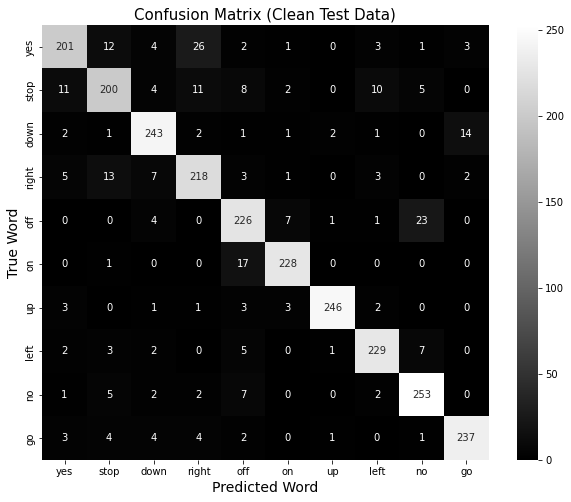

In [17]:
# Visualizing the result as a confusion matrix

plt.figure(figsize = (10,8))
sns.heatmap(confusion_matrix(result['Word'], result['Predicted']), cmap = 'gray', annot = True, fmt=".0f",
            xticklabels= word_dict.values(), yticklabels= word_dict.values());
plt.ylabel('True Word', fontsize = 14)
plt.xlabel('Predicted Word', fontsize = 14)
plt.title('Confusion Matrix (Clean Test Data)', fontsize = 15);

In [18]:
print(classification_report(result['Word'], result['Predicted']))

              precision    recall  f1-score   support

        down       0.88      0.79      0.84       253
          go       0.84      0.80      0.82       251
        left       0.90      0.91      0.90       267
          no       0.83      0.87      0.84       252
         off       0.82      0.86      0.84       262
          on       0.94      0.93      0.93       246
       right       0.98      0.95      0.96       259
        stop       0.91      0.92      0.92       249
          up       0.87      0.93      0.90       272
         yes       0.93      0.93      0.93       256

    accuracy                           0.89      2567
   macro avg       0.89      0.89      0.89      2567
weighted avg       0.89      0.89      0.89      2567



## Comments:

We get an **accuracy of 89 %** on the clean test data, where accuracy is :

(number of utterances correctly classified) / (total number of utterances in test data)

From the confusion matrix we can identify which are the most confused classes. For example, "yes" has been predicted 26 times as "right". Comparing individual words by f1-score, we find that the maximum f1-score (which is the harmonic mean of precision and recall) is for the word "right" which can be attributed to the fact that it has less commonalities with other words in the data. 

# Task B: Test Data With Noise

We repeat the same procedure this time on the MFCC features extracted from the noisy test data

In [54]:
df_test = pd.read_csv('test_endpt_preemph_noisy_NEW.csv')
metadata_test_clean = pd.read_csv('metadata_test_noisy.csv')

In [55]:
word_dict = dict([(x, df_test['Word'].unique()[x]) for x in range(10)])

In [56]:
result = metadata_test_clean.copy()
predictions = []

for filepath in df_test['Filepath'].unique():
    
    real = df_test.loc[df_test['Filepath'] == filepath]['Word'].values[0] #actual word in this utterance
    X = np.array(df_test.loc[df_test['Filepath'] == filepath].iloc[:,4:])
    lengths = [len(X)]
    
    scores = []
    for model in models:
        scores.append(model.score(X, lengths)) #log probability under the model.
    
    pred = word_dict[np.argmax(np.array(scores))] #predicted word:  one which has maximum (least negative) score

    predictions.append(pred) 

In [57]:
result['Predicted'] = predictions

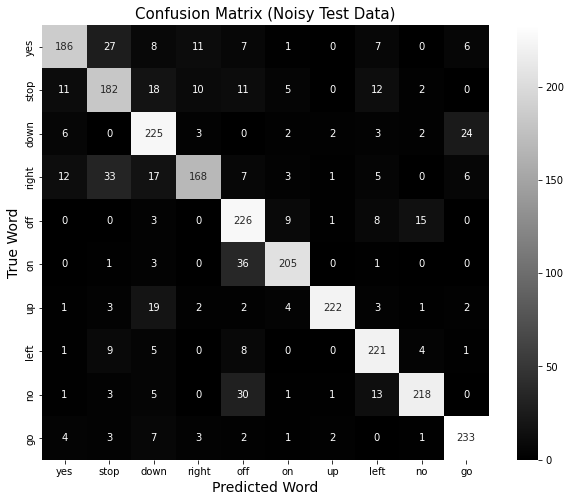

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

plt.figure(figsize = (10,8))
sns.heatmap(confusion_matrix(result['Word'], result['Predicted']), cmap = 'gray', annot = True, fmt=".0f",
            xticklabels= word_dict.values(), yticklabels= word_dict.values());
plt.ylabel('True Word', fontsize = 14)
plt.xlabel('Predicted Word', fontsize = 14)
plt.title('Confusion Matrix (Noisy Test Data)', fontsize = 15);

In [59]:
print(classification_report(result['Word'], result['Predicted']))

              precision    recall  f1-score   support

        down       0.84      0.74      0.78       253
          go       0.70      0.73      0.71       251
        left       0.73      0.84      0.78       267
          no       0.85      0.67      0.75       252
         off       0.69      0.86      0.76       262
          on       0.89      0.83      0.86       246
       right       0.97      0.86      0.91       259
        stop       0.81      0.89      0.85       249
          up       0.90      0.80      0.85       272
         yes       0.86      0.91      0.88       256

    accuracy                           0.81      2567
   macro avg       0.82      0.81      0.81      2567
weighted avg       0.82      0.81      0.81      2567



# Comments:

We see that the accuracy has fallen to **81%** from 89%. The f1 scores have also fallen. From the confusion matrix we can see that the most confused pairs are : on predicted as off and right predicted as stop. These maybe because of some common phones in the words.

# Extra: Predicting In Real Time

In [44]:
import sounddevice as sd
from scipy.io.wavfile import write

def predict_word(file = None):

    if file:
        audio, samprate = sf.read(file)
    else:
        fs = 16000  # Sample rate
        seconds = 1  # Duration of recording

        myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
        sd.wait()  # Wait until recording is finished
        write('user_voice.wav', fs, myrecording)  # Save as WAV file 

        audio, samprate = sf.read("user_voice.wav")
    
    #End pointing 
    thresh = 0.1
    start_idx = 0
    for idx, value in enumerate(audio):
        if np.mean(abs(audio[idx:idx+1000])) > thresh * audio.max():
            start_idx = idx
            break
    end_idx = 0    
    for idx,value in enumerate(np.flip(audio)):
        if np.mean(abs(np.flip(audio)[idx:idx+1000])) > thresh * audio.max():
            end_idx = idx
            break
    audio = audio[start_idx:-(end_idx+1)]

    #Pre-emphasis
    shifted = np.array([0] + list(audio[:-1])) # x[n-1] --> x shifted to the right by 1
    audio = audio - 0.95 * shifted
    
    mfcc = librosa.feature.mfcc(audio, sr = samprate, n_mfcc=13, win_length = 320, hop_length = 160) # 160 samples - 0.01 s
    mfcc_delta = librosa.feature.delta(mfcc, mode = 'constant')
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2, mode = 'constant')
    feat_mat = np.concatenate([mfcc, mfcc_delta, mfcc_delta2]).T

    X = feat_mat.copy()
    
    lengths = [len(X)]

    scores = []
    for model in models:
        scores.append(model.score(X, lengths))

    pred = word_dict[np.argmax(np.array(scores))] #predicted word
    
    print(pred)
    print(np.array([(i,scores[i], word_dict[i]) for i in range(10)]))

#### Run the following cell and a say a word (fairly clearly and loudly) out of the 10 words quickly (within 1 second) !!

In [50]:
predict_word()

up
[['0' '-2552.678866457481' 'yes']
 ['1' '-2375.9840697221475' 'stop']
 ['2' '-2444.2412717887396' 'down']
 ['3' '-2534.669119595774' 'right']
 ['4' '-2327.7883036747758' 'off']
 ['5' '-2413.382339479745' 'on']
 ['6' '-2325.765436772046' 'up']
 ['7' '-2446.1422115524724' 'left']
 ['8' '-2425.2307251636366' 'no']
 ['9' '-2417.749033288883' 'go']]


#### Can also take as input a wav file path and predict:

In [51]:
predict_word("down.wav")

down
[['0' '-4072.675731083883' 'yes']
 ['1' '-3893.330246802795' 'stop']
 ['2' '-3849.868478812968' 'down']
 ['3' '-4043.561670101216' 'right']
 ['4' '-4002.489243329369' 'off']
 ['5' '-4012.5328023184975' 'on']
 ['6' '-3979.293466497243' 'up']
 ['7' '-4004.9403213394758' 'left']
 ['8' '-3868.1754950164873' 'no']
 ['9' '-3855.2576720263764' 'go']]
